# Devoir maison n°1 : Intervalles de confiance et méthodes gloutonnes

*TELECOM ParisTech 2015/2016 - MDI720*

Guillaume MOHR

Ce fichier a été testé dans l'environnement Anaconda, à jour, version Python 3.4.3.
La conformité PEP8 des cellules de code a été testée grâce à l'extention **pep8** d'IPython Notebook : https://github.com/ipython/ipython/wiki/Extensions-Index#pep8

---

## Préliminaires

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
import statsmodels.formula.api as smf
import statsmodels.datasets
from sklearn.preprocessing import scale
from sklearn import linear_model
from sklearn.utils import resample
import statsmodels.api as sm
from scipy.stats.mstats import mquantiles
from sklearn.linear_model.base import LinearModel
from sklearn.base import RegressorMixin
from sklearn.cross_validation import KFold

In [7]:
# Uncomment below for using ipython notebook PEP8 checking extension
# %install_ext https://raw.githubusercontent.com/SiggyF/notebooks/master/pep8_magic.py
# %load_ext pep8_magic

In [8]:
pd.set_option('precision', 5)
%matplotlib inline
sns.set_palette('colorblind')
sns.set_style('darkgrid')
sns.set_context('notebook')

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


---------

## Exercice 1

### Question 1.1

Nous notons dans l'exercice $n$ le nombre d'observations et $p$ le nombre de variables explicatives (hors constante). Le modèle que l'on considère est le suivant :
$$\mathbf{y} = X \mathbf{\theta^*} + \mathbf{\epsilon}$$
$$\textrm{avec}\space \epsilon \sim \cal{N} \mathrm{(0, \sigma^2 \text{I}_n)}$$
$$X \in\mathbb{R}^{n\times (p+1)}, \mathbf{y}\in\mathbb{R}^{n}, \mathbf{\theta^*}\in\mathbb{R}^{p+1} $$
Le $(p+1)$ est dû au fait que l'on prend en compte la variable constante. Dans la suite, ce sera la première colonne de $X$ qui sera constante.  

### Question 1.2

On extrait le jeu de données.

In [9]:
dat1 = statsmodels.datasets.get_rdataset('airquality').data

In [10]:
dat1.head(5)

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41,190,7.4,67,5,1
1,36,118,8.0,72,5,2
2,12,149,12.6,74,5,3
3,18,313,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5


### Question 1.3

 On supprime les lignes contenant une valeur *NaN*.  
 De plus, pour faciliter la manipulation avec des noms de colonnes, on supprime la ponctuation des noms.

In [11]:
dat1 = dat1.dropna()
dat1.rename(columns={'Solar.R': 'SolarR'}, inplace=True)

In [12]:
dat1.head(5)

,Ozone,SolarR,Wind,Temp,Month,Day
0,41,190,7.4,67,5,1
1,36,118,8.0,72,5,2
2,12,149,12.6,74,5,3
3,18,313,11.5,62,5,4
6,23,299,8.6,65,5,7


Par ailleurs, pour la suite, nous pouvons définir numériquement les variables $n$ et $p$ définies plus haut :

In [13]:
(n, p) = dat1.loc[:, 'SolarR':'Day'].shape
print('n = {}\np = {}'.format(n, p))

n = 111
p = 5


Enfin, vérifions que la matrice $X$ est bien de **plein rang**, i.e. $\text{rang}(X)=p+1$:

In [14]:
X = np.hstack([np.ones((n, 1)), dat1.loc[:, 'SolarR':'Day']])
print('Rang de X = {}'.format(np.linalg.matrix_rank(X)))

Rang de X = 6


### Question 1.4

On ajuste le modèle par la méthode des moindres carrés, avec réduction et centrage des variables explicatives.  
*Note 1 : la formule ajoute une constante par défaut, aussi le '1 +' n'est là que pour clarifier nos intentions d'avoir une constante.*  
*Note 2 : on ne centre-réduit pas la variable à prédire.*

In [15]:
regression1 = smf.ols('Ozone ~ 1 + standardize(SolarR) + standardize(Wind) +' +
                      ' standardize(Temp) + standardize(Month) +' +
                      ' standardize(Day)',
                      data=dat1).fit()

### Question 1.5

L'estimateur des coefficients selon le modèle des moindres carrés est :

In [16]:
print(regression1.params)

Intercept              42.09910
standardize(SolarR)     4.56193
standardize(Wind)     -11.75277
standardize(Temp)      17.98522
standardize(Month)     -4.45895
standardize(Day)        2.37394
dtype: float64


Notons d'abord un résultat préliminaire :  
Comme $y = X\theta^*+\epsilon$, que $X,\theta^*$ ne sont pas aléatoires et que $\mathbb{E}[\epsilon]=0$ :
\begin{equation}
\mathbb{E}[yy^T] = \mathbb{E}[\epsilon\epsilon^T] = \sigma² I_n
\end{equation} 


Notons $r = y - \widehat{y}$ les résidus, où $\widehat{y} = X\widehat{\theta} = X(X^TX)^{-1}X^Ty = H_X y$.  
Rappelons que $H_X$ correspond à la projection sur l'espace engendré par les colonnes de $X$.  
Considérons l'estimateur de la variance du bruit suivant :  
$$\widehat{\sigma}^2 = \frac{ ||r||²}{n-p-1}$$  

Vérifions qu'il est sans biais :
\begin{equation}
\begin{split}
\mathbb{E}[\widehat{\sigma}²] & = \frac{1}{n-p-1} \mathbb{E}[r^Tr] \\
& = \frac{1}{n-p-1} \mathbb{E}[(y - H_X y)^T(y - H_X y)] \\
& = \frac{1}{n-p-1} \mathbb{E}[y^T(I_n - H_X)^T(I_n - H_X)y] \\
& = \frac{1}{n-p-1} \text{tr}\space\mathbb{E}[y^T(I_n - H_X)^T(I_n - H_X)y] \space \text{car la trace d'un réel est égale à lui-même} \\
& = \frac{1}{n-p-1} \mathbb{E}[\text{tr}(y^T(I_n - H_X)^T(I_n - H_X)y)] \space\textrm{car la trace est linéaire} \\
& = \frac{1}{n-p-1} \mathbb{E}[\text{tr}((I_n - H_X)yy^T(I_n - H_X)^T)] \space\text{puisqe tr}(AB) = \text{tr}(BA) \\
& = \frac{1}{n-p-1} \text{tr}\mathbb{E}[(I_n - H_X)yy^T(I_n - H_X)^T] \space\text{toujours puisque la trace est linéaire} \\
& = \frac{1}{n-p-1} \text{tr}((I_n - H_X)\mathbb{E}[yy^T](I_n - H_X)^T) \space\text{car }I_n \text{et} H_X \text{ne sont pas aléatoires} \\
& = \frac{\sigma²}{n-p-1} \text{tr}((I_n - H_X)(I_n - H_X)^T) \space\text{d'après le résultat préliminaire} \\
& = \frac{\sigma²}{n-p-1} \text{tr}(I_n - H_X) \space\text{puisque }I_n - H_X\text{ est un projecteur orthogonal donc symétrique et idempotent} \\
& = \frac{\sigma²}{n-p-1}(n - (p+1)) \space\text{puisque } X \text{ est de plein rang, que la trace d'un projecteur est égale à son rang, et que rg}(H_X) = \text{rg}(X) \\
& = \sigma²
\end{split}
\end{equation}

Calculons numériquement $\widehat{\sigma}²$ :

In [17]:
r = regression1.resid
sigmaHat_sq = r.T.dot(r) / (n - p - 1)
print("Estimation de la variance du bruit : {:0.5f}".format(sigmaHat_sq))

Estimation de la variance du bruit : 435.07549


Remarquons que le package *statsmodels* nous donne directement la valeur avec la *mean sqared error* :

In [18]:
print("MSE = {:0.5f}".format(regression1.mse_resid))

MSE = 435.07549


### Question 1.6 

Puisque :
$$\forall u \in \mathbb{R}^{p+1}, \frac{u^T(\widehat{\theta} - \theta^*)}{\widehat{\sigma}\sqrt{u^T(X^T X)^{-1}u}} \sim \mathcal{T}_{n-p-1}$$
Alors on a en particulier pour tout vecteur de la base orthonormée $e^{(i)} \in \mathbb{R}^{p+1}$ défini par 
$\forall k \in \{1, ...,p+1\}, e^{(i)}_k = \delta^i_k$ :
$$\frac{{e^{(i)}}^T(\widehat{\theta} - \theta^*)}{\widehat{\sigma}\sqrt{{e^{(i)}}^T(X^T X)^{-1}e^{(i)}}} \sim \mathcal{T}_{n-p-1}$$
$$\frac{\widehat{\theta}_i - \theta^*_i}{\widehat{\sigma}\sqrt{(X^T X)^{-1}_{i,i}}} \sim \mathcal{T}_{n-p-1}$$
Alors, en notant $t_{1 - \alpha/2}$ le quantile d'ordre $1 - \alpha/2$ de cette loi de Student, on a pour tout $\theta^*_i$ l'intervalle de confiance suivant :
$$\left[\widehat{\theta}_i - \widehat{\sigma}\sqrt{(X^T X)^{-1}_{i,i}}t_{1 - \alpha/2} \space , \space \widehat{\theta}_i + \widehat{\sigma}\sqrt{(X^T X)^{-1}_{i,i}}t_{1 - \alpha/2}\right]$$

Réglons le niveau de $\alpha = 1\%$ (soit un intervalle de confiance à 99%).

In [19]:
alpha = 0.01

En utilisant les fonctions du package *statsmodels* :

In [20]:
regression1.conf_int(alpha=alpha)

,0,1
Intercept,36.90517,47.29303
standardize(SolarR),-1.01299,10.13685
standardize(Wind),-17.74117,-5.76437
standardize(Temp),11.16854,24.80190
standardize(Month),-10.28281,1.36491
standardize(Day),-2.84875,7.59663


En utilisant directement la formule ci-dessus, on trouve évidemment la même chose :

In [21]:
# On doit centrer et réduire X:
X[:, 1:] = scale(X[:, 1:])
XXTinv = np.linalg.inv(X.T.dot(X))
intervals1 = pd.DataFrame([regression1.params[:], regression1.params[:]],
                          index=['LowerBound', 'UpperBound']).T
w = np.sqrt(sigmaHat_sq * XXTinv.diagonal()) * t.ppf(1 - alpha / 2, df=n-p-1)
intervals1.LowerBound -= w
intervals1.UpperBound += w
intervals1

,LowerBound,UpperBound
Intercept,36.90517,47.29303
standardize(SolarR),-1.01299,10.13685
standardize(Wind),-17.74117,-5.76437
standardize(Temp),11.16854,24.80190
standardize(Month),-10.28281,1.36491
standardize(Day),-2.84875,7.59663


### Question 1.7

On remarque que les intervalles de confiance à 99% des coefficients associés aux variables *Month* et *Day* contiennent la valeur zéro. **On ne peut donc pas rejeter l'hypothèse que leur coefficient est nul** (c'est-à-dire que les variables n'ont aucune influence sur les observations).  
*Remarquons que la variable *SolarR* est dans la même situation*.

### Question 1.8

In [22]:
obs1 = pd.DataFrame({'SolarR': [197], 'Wind': [10], 'Temp': [70],
                     'Day': [1], 'Month': [3]})
print("Prédiction de la nouvelle observation = {:.5f}".format(
        regression1.predict(obs1)[0]))

Prédiction de la nouvelle observation = 36.46234


***

## Exercice 2

### Question 2.1

Dans cet exercice, nous utilisons directement la version centrée réduite des variables explicatives calculée dans la question 1.6.

In [23]:
y = dat1[['Ozone']]
print("Moyennes des colonnes de X :\n {}".format(X.mean(axis=0)))
print("Variances des colonnes de X :\n {}".format(X.var(axis=0)))

Moyennes des colonnes de X :
 [  1.00000000e+00  -1.50530239e-16   2.94559172e-16  -2.40048222e-16
   2.24045007e-16   1.20024111e-17]
Variances des colonnes de X :
 [ 0.  1.  1.  1.  1.  1.]


Par ailleurs, puisqu'il s'agit de réaliser un grand nombre d'itérations, nous utiliserons la librairie  *sklearn.linear_model.LinearRegression* qui apparaît plus rapide que *statsmodels* pour le calcul des coefficients de régression :  
*Sur mon PC, j'obtiens un temps de calculs double pour sm.OLS (741 microsecondes) vs. linear_model.LinearRegression (357 microsecondes).*

In [24]:
%timeit linear_model.LinearRegression(fit_intercept=False).fit(X, y).coef_

The slowest run took 5.93 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 225 µs per loop


In [25]:
%timeit sm.OLS(y, X, hasconst=True).fit().params

1000 loops, best of 3: 460 µs per loop


In [26]:
def getResampledCoefs(Xy, model):
    """ Returns an array of B OLS coefficients """
    Xy_r = resample(Xy)
    Xy_split = np.split(Xy_r, [-1], axis=1)
    X = Xy_split[0]
    y = Xy_split[1]
    coefs = model.fit(X, y).coef_[0]
    return coefs

Suivons les recommandations de l'énoncé sur le nombre $B$ d'échantillons puis calculons les estimations des paramètres que l'on stocke dans un tableau **coefs_boostrap** :  

In [27]:
B = 10000
Xy = np.hstack([X, y])
model = linear_model.LinearRegression(fit_intercept=False)

coefs_bootstrap = pd.DataFrame(
    [getResampledCoefs(Xy, model) for i in range(B)])
coefs_bootstrap.columns = regression1.params.index

In [28]:
coefs_bootstrap.head(5)

,Intercept,standardize(SolarR),standardize(Wind),standardize(Temp),standardize(Month),standardize(Day)
0,42.75348,4.97762,-11.94471,17.93701,-6.65306,3.72451
1,36.52191,2.82845,-8.65611,16.53341,-4.47848,3.14844
2,40.15031,3.66261,-11.22736,18.55668,-2.16669,-0.49952
3,41.31967,5.51329,-7.78635,19.39258,-2.14167,4.53872
4,40.75958,4.28550,-11.83951,17.69238,-3.69576,0.08191


Calculons les estimateurs demandés :

In [29]:
coefs_ests = pd.DataFrame({
        'Classic': regression1.params,
        'BsMean': coefs_bootstrap.mean(),
        'BsMedian': coefs_bootstrap.median()
    })
coefs_ests['BsMean:Classic_RelDiff'] = \
    abs(coefs_ests.BsMean - coefs_ests.Classic) / coefs_ests.Classic
coefs_ests['BsMedian:Classic_RelDiff'] = \
    abs(coefs_ests.BsMedian - coefs_ests.Classic) / coefs_ests.Classic

In [30]:
coefs_ests

,BsMean,BsMedian,Classic,BsMean:Classic_RelDiff,BsMedian:Classic_RelDiff
Intercept,41.99826,41.95275,42.09910,0.00240,0.00348
standardize(SolarR),4.58583,4.53521,4.56193,0.00524,0.00586
standardize(Wind),-11.91993,-11.75209,-11.75277,-0.01422,-0.00006
standardize(Temp),18.00059,18.03866,17.98522,0.00085,0.00297
standardize(Month),-4.44463,-4.48953,-4.45895,-0.00321,-0.00686
standardize(Day),2.40015,2.40832,2.37394,0.01104,0.01448


### Question 2.2

In [31]:
intervalsBs = pd.DataFrame(
    data=mquantiles(coefs_bootstrap, prob=[0.005, 0.995], axis=0).T,
    columns=['LowerBound', 'UpperBound'],
    index=coefs_ests.index)
intervalsBs

,LowerBound,UpperBound
Intercept,37.00005,47.48953
standardize(SolarR),-0.22650,9.80585
standardize(Wind),-20.59888,-5.06770
standardize(Temp),12.16096,23.46365
standardize(Month),-9.49028,0.71321
standardize(Day),-3.26117,7.96338


### Question 2.3

In [32]:
def windBounds(B):
    """ Returns the lower and upper bound of the CI for Wind """
    sample = coefs_bootstrap.loc[:B+1, 'standardize(Wind)']
    qs = mquantiles(sample, prob=[0.005, 0.995])
    med = sample.median()
    return qs[0], qs[1], med

In [33]:
Bs = range(1, 5002, 500)
CIsMed = [windBounds(B) for B in Bs]
lCIsMed = list(zip(*CIsMed))
lower = lCIsMed[0]
upper = lCIsMed[1]
med = lCIsMed[2]

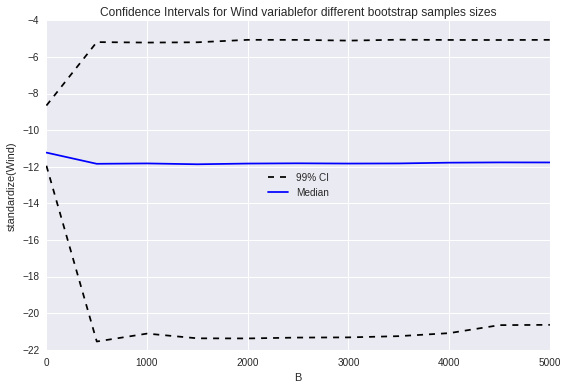

In [34]:
plt.plot(Bs, upper, '--k')
plt.plot(Bs, med, '-b')
plt.plot(Bs, lower, '--k')
plt.title('Confidence Intervals for Wind variable'
          'for different bootstrap samples sizes')
plt.xlabel('B')
plt.ylabel('standardize(Wind)')
plt.xlim(0, 5002)
plt.legend(['99% CI', 'Median'], loc=10)
plt.tight_layout()

### Question 2.4

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


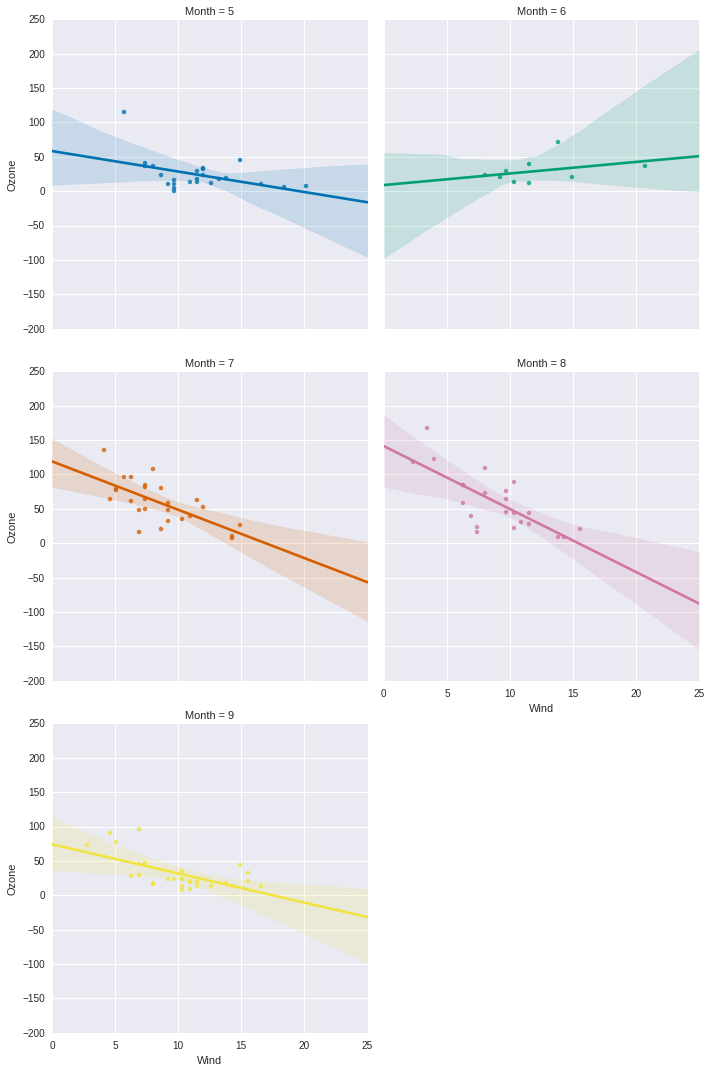

In [35]:
sns.lmplot(data=dat1, x='Wind', y='Ozone', hue='Month',
           col='Month', col_wrap=2, ci=99)

**Le mois de juin (mois numéro 6) semble atypique** puisque c'est le seul où le vent a une influence positive (pente positive) sur la concentration en ozone.  
On note cependant également que ce mois a également un intervalle de confiance plus élargi que les autres. En particulier, on ne peut pas rejeter l'hypothèse comme quoi le coefficient est en réalité négatif ou nul.

***

## Excercice 3

### Question 3.1

In [36]:
def stpforward(y, X, M, addIntercept=True):
    """
    Implementation de l'algorithme forward stage-wise selection
    ou Orthogonal Matching Mursuite
    Arguments:
    ----------
    y : a numpy array of shape (n, 1)
    X : a numpy array of shape (n, p)
    M : number of variables we want to select
        M needs to be less of equal to the number of X columns
    addIntercept : True if we want to fit an intercept
    Returns:
    --------
    theta : a numpy (p,) array
    S : the list of column indexes selected
    theta_0 : the intercept value
             (will be 0.0 if addIntercept=False)
    """
    (n, p) = X.shape
    if M > p:
        raise ValueError('M cannot be larger than '
                         'the number of X columns!')
    theta = np.zeros((p,))
    r = y
    S = []
    for i in range(M):
        jmax = -1
        alphajmax = -1
        for j in (k for k in range(p) if k not in S):
            alphaj = abs(X[:, j].T.dot(r))
            if alphaj > alphajmax:
                jmax = j
                alphajmax = alphaj
        S.append(jmax)
        regression = linear_model.LinearRegression(
            fit_intercept=addIntercept).fit(X[:, S], y)
        theta_int = regression.coef_.T
        theta_0 = regression.intercept_  # equals 0 if no intercept
        r = y - X[:, S].dot(theta_int) - theta_0
    theta[S] = theta_int.reshape((M,))
    return theta, S, theta_0

### Question 3.2

Afin de produire une classe utile pour notre  exercice, nous avons fait les principales modifications suivantes :

* remplacement de *normalize=True* (qui ne fonctionne a priori pas) par ***standardize=True* pour indiquer si l'on souhaite ou non centrer-réduire les variables explicatives et implémentation d'une méthode qui effectue l'opération** ;
* suppression de l'appel à la fonction *_pre_fit* qui ne nous intéresse pas (nous ne nous servirons que de notre fonction *stpforward*) et donc suppression de la variable *precompute='auto'* ;
* gestion du parmètre n_non_zero_coefs qui doit être compris entre 1 et p. Ce paramètre correspond à la variable *M* de la fonction précédente ;
* gestion des inputs afin que soient acceptés des DataFrames, des Array et des Series (pour le y) et que les noms de variables soient conservés pour la sortie (c'est quand même plus explicite que des numéros !) ;
* création d'une méthode *predict* permettant de faire des prédictions (prenant en compte le fait que l'on ait ou non réduit les variables explicatives).

In [37]:
class MYOMP(LinearModel, RegressorMixin):
    """
    Main class attributes (self.)
    -----------------------------
    n, p : sample size, number of features
    X_mask : mask which ignores constant columns
    X_mean : mean of each column
    X_std : std of each column
    X_names : features names
    y_name : name of the predicted variable
    standardize : if True will standardize the explicative variables
    fit_intercept : if True will fit an intercept
    n_nonzero_coefs : number of features we want to keep
    nonzero_coefs : list of index of features kept
    coef_ : vector of fitted parameters
    intercept_ : value of the intercept
    """

    def __init__(self, n_nonzero_coefs=None, fit_intercept=True,
                 standardize=True):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.fit_intercept = fit_intercept
        self.standardize = standardize

    def standardizeX(self, X):
        """
        Substract to each column of X its mean and divides it by
        its standrd deviation.
        It should ignore constant columns thanks to the X_mask.
        It also modify the X variable names by adding a 'std' in
        front.
        """
        X[:, self.X_mask] = \
            (X[:, self.X_mask] - self.X_mean[self.X_mask]) \
            / self.X_std[self.X_mask]
        newNames = []
        for i, name in enumerate(self.X_names):
            if self.X_mask[i]:
                newNames.append('std(' + name + ')')
            else:
                newNames.append(name)
        self.X_names = np.array(newNames)
        return X

    def preprocess(self, X, y):
        """
        Extracts information about the input, such as:
        - variables names (useful when working with Pandas),
        - mean, standard deviation (for scaling and reverse
          scaling for prediction)
        Formats data as numpy array for computations
        Standardizes data if necessary
        """
        self.n, self.p = X.shape

        # We try X as a pandas dataframe
        if isinstance(X, pd.core.frame.DataFrame):
            self.X_names = np.array(X.columns)
            X = X.values
        else:
            X = np.array(X)
            self.X_names = np.array(['x' + str(i) for i in range(p)])

        # We try y as a pandas DataFrame of Series
        if isinstance(y, pd.core.frame.DataFrame):
            self.y_name = np.array(y.columns)
            y = y.values
        elif isinstance(y, pd.core.series.Series):
            self.y_name = np.array([y.name])
            y = y.values
        else:
            self.y = np.array(y)
            self.y_name = np.array(['y'])
        y = y.reshape((self.n, 1))

        self.X_std = X.std(axis=0)
        self.X_mean = X.mean(axis=0)
        self.X_mask = np.array([True] * self.p)
        # If a column is constant (std = 0), it is set to ones.
        for i, s in enumerate(self.X_std):
            if s == 0:
                X[:, i] = 1
                self.X_mask[i] = False

        if self.standardize:
            X = self.standardizeX(X)

        return X, y

    def fit(self, X, y):
        """Fit the model using X, y as training data.
        Parameters
        ----------
        X : either a Numpy Array of a Pandas Dataframe of shape (n, p)
        y : a Numpy Array, a Pandas Dataframe of Series of shape (n,) or (n, 1)
        Returns
        -------
        self : object
            returns an instance of self.
        """
        X, y = self.preprocess(X, y)

        if self.n_nonzero_coefs not in range(1, self.p + 1):
            raise ValueError('Number of features to select must'
                             'be comprised between 1 and ' + str(self.p))

        self.coef_, self.nonzero_coefs, self.intercept_ = \
            stpforward(y, X, self.n_nonzero_coefs,
                       self.fit_intercept)

        self.coef_ = pd.Series(data=self.coef_,
                               index=self.X_names)
        self.intercept_ = pd.Series(data=self.intercept_,
                                    index=['Intercept'])
        return self

    def predict(self, X):
        """
        Predicts the values of y using the fitted model
        Parameters:
        -----------
        X : array of shape (m, self.p)
        Returns:
        --------
        y : vector of shape (m,)
        """
        X = np.array(X)
        m, p = X.shape
        if p != self.p:
            raise ValueError('X must have {} columns!'.format(self.p))
        # First we need to center & reduce the new X
        if self.standardize:
            X = (X[:, self.X_mask] - self.X_mean[self.X_mask]) \
                / self.X_std[self.X_mask]
        y = X.dot(self.coef_) + self.intercept_.values
        return y

### Question 3.3

Tirons profit de notre nouvelle classe qui est capable de traiter les données à la source sans transformation manuelle préliminaire :

In [38]:
def resultsForM(M):
    myomp = MYOMP(M, fit_intercept=True, standardize=True).fit(
        dat1.ix[:, 1:], dat1.Ozone)
    print("========================")
    print("For M = {}".format(M))
    print("Features :")
    print("----------------------")
    print(myomp.coef_)
    print("\n")
    print("Intercept :")
    print("----------------------")
    print(myomp.intercept_)
    print("========================")

In [39]:
for i in [3, 4, 5]:
    resultsForM(i)

For M = 3
Features :
----------------------
std(SolarR)     5.42817
std(Wind)     -11.80642
std(Temp)      15.67331
std(Month)      0.00000
std(Day)        0.00000
dtype: float64


Intercept :
----------------------
Intercept    42.0991
dtype: float64
For M = 4
Features :
----------------------
std(SolarR)     4.50045
std(Wind)     -11.74592
std(Temp)      17.74888
std(Month)     -4.38807
std(Day)        0.00000
dtype: float64


Intercept :
----------------------
Intercept    42.0991
dtype: float64
For M = 5
Features :
----------------------
std(SolarR)     4.56193
std(Wind)     -11.75277
std(Temp)      17.98522
std(Month)     -4.45895
std(Day)        2.37394
dtype: float64


Intercept :
----------------------
Intercept    42.0991
dtype: float64


### Question 3.4

Effectuons les mêmes estimations avec *OrthogonalMatchingPursuit* de *sklearn* et comparons avec nos résultats.

In [40]:
def resultsForM2(M):
    myomp = MYOMP(M, fit_intercept=True,
                  standardize=True).fit(dat1.ix[:, 1:], dat1.Ozone)
    skomp = linear_model.OrthogonalMatchingPursuit(
        M, fit_intercept=True).fit(X[:, 1:], y)
    results = pd.DataFrame(data={
            'MyOMP': np.hstack([myomp.coef_, myomp.intercept_]),
            'SklearnOMP': np.hstack([skomp.coef_, skomp.intercept_])},
                           index=np.hstack([myomp.coef_.index,
                                            myomp.intercept_.index]))
    print("===================================")
    print("For M = {}".format(M))
    print(results)
    print("===================================")

In [41]:
for i in [3, 4, 5]:
    resultsForM2(i)

For M = 3
                MyOMP  SklearnOMP
std(SolarR)   5.42817     5.42817
std(Wind)   -11.80642   -11.80642
std(Temp)    15.67331    15.67331
std(Month)    0.00000     0.00000
std(Day)      0.00000     0.00000
Intercept    42.09910    42.09910
For M = 4
                MyOMP  SklearnOMP
std(SolarR)   4.50045     4.50045
std(Wind)   -11.74592   -11.74592
std(Temp)    17.74888    17.74888
std(Month)   -4.38807    -4.38807
std(Day)      0.00000     0.00000
Intercept    42.09910    42.09910
For M = 5
                MyOMP  SklearnOMP
std(SolarR)   4.56193     4.56193
std(Wind)   -11.75277   -11.75277
std(Temp)    17.98522    17.98522
std(Month)   -4.45895    -4.45895
std(Day)      2.37394     2.37394
Intercept    42.09910    42.09910


On trouve bien la même chose.

### Question 3.5

En utilisant la technique de validation croisée K-fold vue en cours, nous allons évaluer pour toutes les valeurs de M possibles (de 1 à 5) la performance de la prédiction.  
Nous utilisons la fonction *KFold* du package *sklearn.cross_validation* afin de partitionner l'ensemble des observations. **Nous exigeons que les données soient mélangées aléatoirement** (ce qui n'est pas le comportement par défaut de la fonction).

L'erreur de prédiction pour 1 *fold* que nous utilisons est :
$$\widehat{\text{erreur}} = \left|\left|X_\text{test}\widehat{\theta}_\text{train} - y_\text{test}\right|\right|^2_2$$

In [42]:
def errorKFold(M, dat, kf):
    """
    Computes prediction errors using CV technique
    Parameters:
    -----------
    M - number of features to retain
    data - dataframe ; first columns is the observed variable
           other columns are the explicative variables
    kf - KFold result, splittin the data
    Returns:
    --------
    vector of errors
    """
    error = []
    for train_index, test_index in kf:
        X_train, y_train = dat.iloc[train_index, 1:], dat.iloc[train_index, 0]
        X_test, y_test = dat.iloc[test_index, 1:], dat.iloc[test_index, 0]
        myomp = MYOMP(M, fit_intercept=True,
                      standardize=True).fit(X_train, y_train)
        y_hat = myomp.predict(X_test).reshape(y_test.size)
        dy = y_test - y_hat
        error.append(dy.dot(dy))
    return np.array(error)

Afin de décider, nous allons étudier l'évolution des erreurs de prédiction en fonction du nombre $M$ de variables explicatives à conserver, mais aussi du nombre $K$ de *folds*.

In [43]:
def computeKFolds(K):
    """
    For K folds, compute the prediction errors for each M
    Returns:
    --------
    best M according to the average prediction error
    average prediction errors
    the computed errors
    """
    Ms = range(1, p + 1)
    errors = pd.DataFrame(data=np.zeros((K * len(Ms), 2)),
                          columns=['M', 'PredictionError'])
    kf = KFold(n=dat1.shape[0], n_folds=K, shuffle=True)
    for i, M in enumerate(Ms):
        errors.M[i*K:(i+1)*K] = M
        errors.PredictionError[i*K:(i+1)*K] = errorKFold(M, dat1, kf)
    results = errors.groupby('M').mean().sort('PredictionError')
    best_M = int(results.index[0])
    return best_M, results, errors

In [44]:
def plotKFolds(K):
    """
    (i)  print the prediction error means for each M,
         in increasing order
    (ii) plot the distribution of prediction errors for
         all the possible Ms, as box plots
    """
    best_M, results, errors = computeKFolds(K)
    print("Lowest average prediction error for M={}".format(best_M))
    print(results)
    sns.boxplot(data=errors, x='M', y='PredictionError')

On observe que ces calculs ne donnent pas de claire indication sur la meilleure valeur de *M* (les moyennes des erreurs sont relativement proches) :

Lowest average prediction error for M=5
   PredictionError
M                 
5       5314.14174
4       5452.87413
2       5539.11596
3       5735.90663
1       6391.04818


/usr/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


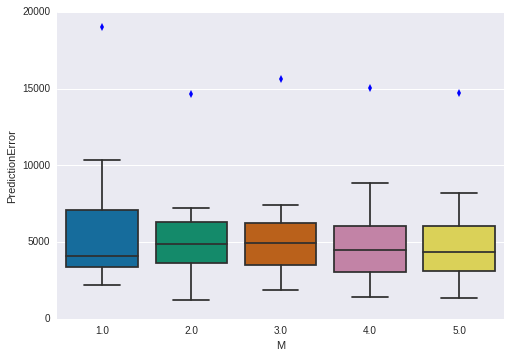

In [45]:
plotKFolds(10)

Par ailleurs, pour plusieurs valeurs de K (2, 5, 10), la valeur de M la plus performante n'est pas stable selon les *runs*:

In [46]:
Ks = [2, 5, 10]
best_Ms = np.array([[computeKFolds(K)[0] for K in Ks] for i in range(20)])
M_stats = pd.DataFrame(data=best_Ms, columns=Ks)
M_stats = pd.melt(M_stats, value_name="Best M", var_name="K")

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


/usr/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


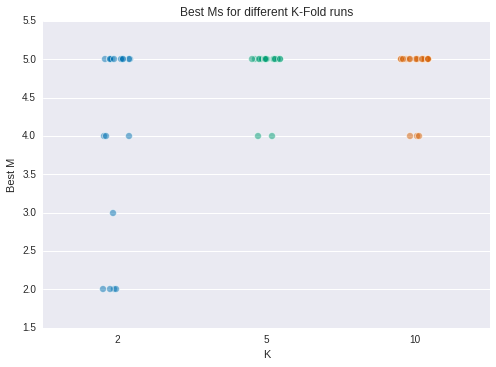

In [47]:
sns.stripplot(x='K', y='Best M', data=M_stats, jitter=True, alpha=0.5)
plt.title('Best Ms for different K-Fold runs')

**Ainsi il apparaît sans doute plus judicieux de conserver l'ensemble des variables (M=5).**  

Enfin, nous pouvons vérifier que ce comportement est comparable à ce que l'on aurait obtenu eussions-nous utilisé la classe *OrthogonalMatchingPursuitCV* du package *sklearn.linear_model*.

In [48]:
Ks = [2, 5, 10]
n = dat1.shape[0]
Xompcv = X[:, 1:]
yompcv = np.array(y).reshape((n,))


def findBestM(K):
    cv = KFold(n=n, n_folds=K, shuffle=True)
    ompcv = linear_model.OrthogonalMatchingPursuitCV(
            fit_intercept=True, cv=cv).fit(Xompcv, yompcv)
    return ompcv.n_nonzero_coefs_

best_Ms = np.array([[findBestM(K) for K in Ks] for i in range(20)])
M_stats = pd.DataFrame(data=best_Ms, columns=Ks)
M_stats = pd.melt(M_stats, value_name="Best M", var_name="K")

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


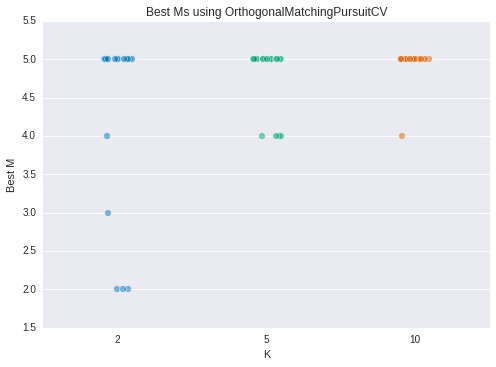

In [49]:
sns.stripplot(x='K', y='Best M', data=M_stats, jitter=True, alpha=0.5)
plt.title('Best Ms using OrthogonalMatchingPursuitCV')